# SNR test

This notebook is to quantify the SNR difference between the star electrode array and the control array.

In [1]:
import pandas as pd
import numpy as np
import scipy

In [2]:
def load_openbci_file(filepath):
    """
    Loads an OpenBCI raw data file into a pandas DataFrame.
    
    Parameters:
    - filepath: str, the path to the OpenBCI text file.
    
    Returns:
    - df: pandas.DataFrame, the loaded data.
    """
    # Determine the number of header lines to skip. We assume the header ends
    # before the column names line, which starts with "Sample Index".
    with open(filepath, 'r') as file:
        header_lines = 0
        for line in file:
            if line.startswith('Sample Index'):
                break
            header_lines += 1
    
    # Load the data, skipping the header lines
    df = pd.read_csv(filepath, skiprows=header_lines)
    
    return df

In [3]:
def compute_snr(signal, noise):
    """
    Computes the Signal-to-Noise Ratio (SNR) in decibels for each channel in (M, N) numpy arrays.
    
    Parameters:
    - signal: numpy.array, the array containing the signal with shape (M, N) where N is the number of channels.
    - noise: numpy.array, the array containing the noise with shape (M, N) or a different number of samples.
    
    Returns:
    - snr_db: numpy.array, the SNR in decibels for each channel.
    """
    # Verify the number of channels matches
    if signal.shape[1] != noise.shape[1]:
        raise ValueError("Signal and noise must have the same number of channels.")
    
    # Initialize an array to hold SNR values for each channel
    snr_db = np.zeros(signal.shape[1])
    
    for i in range(signal.shape[1]):  # Iterate over each channel
        # Compute the power of the signal and noise for the current channel
        signal_power = np.mean(signal[:, i]**2)
        noise_power = np.mean(noise[:, i]**2)
        
        # Ensure noise power is not zero to avoid division by zero
        if noise_power == 0:
            raise ValueError(f"Noise power is zero for channel {i}, cannot compute SNR.")
        
        # Compute the SNR for the current channel
        snr = signal_power / noise_power
        
        # Convert SNR to decibels for the current channel
        snr_db[i] = 10 * np.log10(snr)
    
    return snr_db

In [4]:
sos_highpass = scipy.signal.butter(4, 0.5, 'highpass', fs=250, output='sos')
sos_notch_50hz = scipy.signal.butter(4, [48,52], 'bandstop', fs=250, output='sos')

def apply_biosignal_filters(signal):
    """
    Applies filters to a biosignal to remove noise and artifacts.
    
    Parameters:
    - signal: numpy.array, the array containing the biosignal with shape (M, N) where N is the number of channels.
    
    Returns:
    - filtered_signal: numpy.array, the filtered biosignal with shape (M, N).
    """
    # Apply filters to remove noise and artifacts
    mean_removed = signal - np.mean(signal, axis=0)
    dc_suppressed = scipy.signal.sosfiltfilt(sos_highpass, mean_removed, axis=0, padtype='constant') # only using filt adds artifacting on the initialization
    powerline_suppressed = scipy.signal.sosfiltfilt(sos_notch_50hz, dc_suppressed, axis=0, padtype='constant')
    
    return powerline_suppressed

In [7]:
fin_configuration = ['11', '22', '44', '88', 'control']
base_path = '../../datasets/snr-comparison/1'

for fin in fin_configuration:
    noise_file_path = f"{base_path}/noise-{fin}.txt"
    signal_file_path = f"{base_path}/signal-{fin}.txt"

    df_noise = load_openbci_file(noise_file_path)
    df_signal = load_openbci_file(signal_file_path)

    # Extract the EMG data from the dataframes
    emg_noise = df_noise[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6', ' EXG Channel 7']].values
    emg_signal = df_signal[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6', ' EXG Channel 7']].values

    emg_noise = apply_biosignal_filters(emg_noise)
    emg_signal = apply_biosignal_filters(emg_signal)
    
    emg_signal = emg_signal[(10 * 250):-(10*250), :]
    emg_noise = emg_noise[(10 * 250):-(10*250), :]
    print(emg_signal.shape)

    print(f"Configuration {fin}")
    print(compute_snr(emg_signal, emg_noise))

(25126, 8)
Configuration 11
[ 4.75167296 12.1756302   9.91161044  9.72715529  6.72898387  6.80450849
  8.60814385  7.79054602]
(25429, 8)
Configuration 22
[ 3.50879339  7.17925855 11.76055367 11.05118447  7.84544488  7.71777296
 11.21559777 10.22729854]
(26357, 8)
Configuration 44
[ 5.09994642  7.37649354 11.0615083  10.83236389  6.58823599  6.87862109
  9.15848214  8.5831429 ]
(28629, 8)
Configuration 88
[ 6.1122022   8.8119235  12.72128447 12.95085276  8.13310532  8.22167878
 11.20935355 11.06720712]
(25674, 8)
Configuration control
[8.24220017 0.47619779 5.19274302 5.06566187 1.94978594 2.48945338
 3.76270937 3.50247489]


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/bar_chart.png'

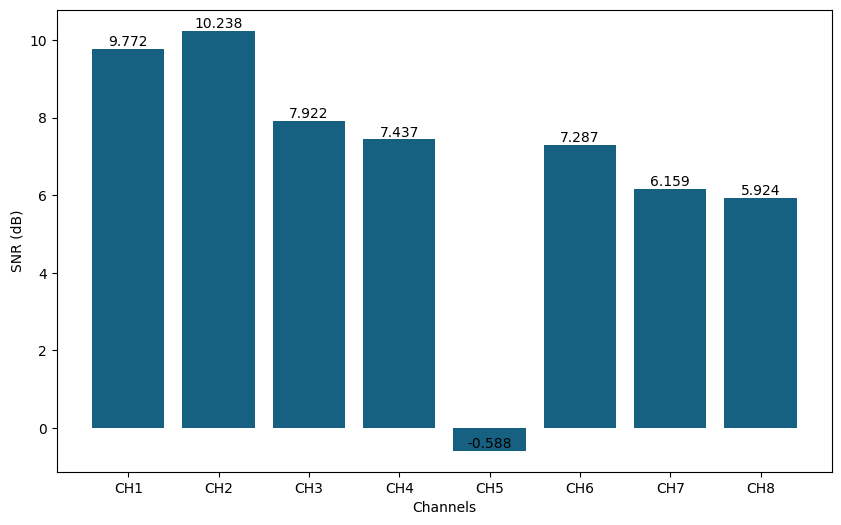

In [13]:
import matplotlib.pyplot as plt

# Data for plotting
# values = [-0.58754899, 9.77243648, 10.23760007, 7.28740225, 5.92392978, 7.43748788, 7.92210553, 6.15925163]
# values = [9.77243648, 10.23760007, 7.92210553, 7.43748788, -0.58754899, 7.28740225,  6.15925163, 5.92392978]

values = [ -2.2217, 6.4940, 8.3554, 9.9622, 8.2352, 7.7643, 9.5980, 3.7036]
          
channels = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']
colors = '#166182'  # Dark Teal color

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(channels, values, color=colors)

# Add the value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center')

# Labeling Axes
plt.xlabel('Channels')
plt.ylabel('SNR (dB)')

# Remove title
plt.title('')

# Save the plot to a file
plt.savefig('/mnt/data/bar_chart.png', bbox_inches='tight')
plt.close()  # Close the figure to prevent it from displaying in the notebook

# Provide the path to the saved image
'/mnt/data/bar_chart.png'


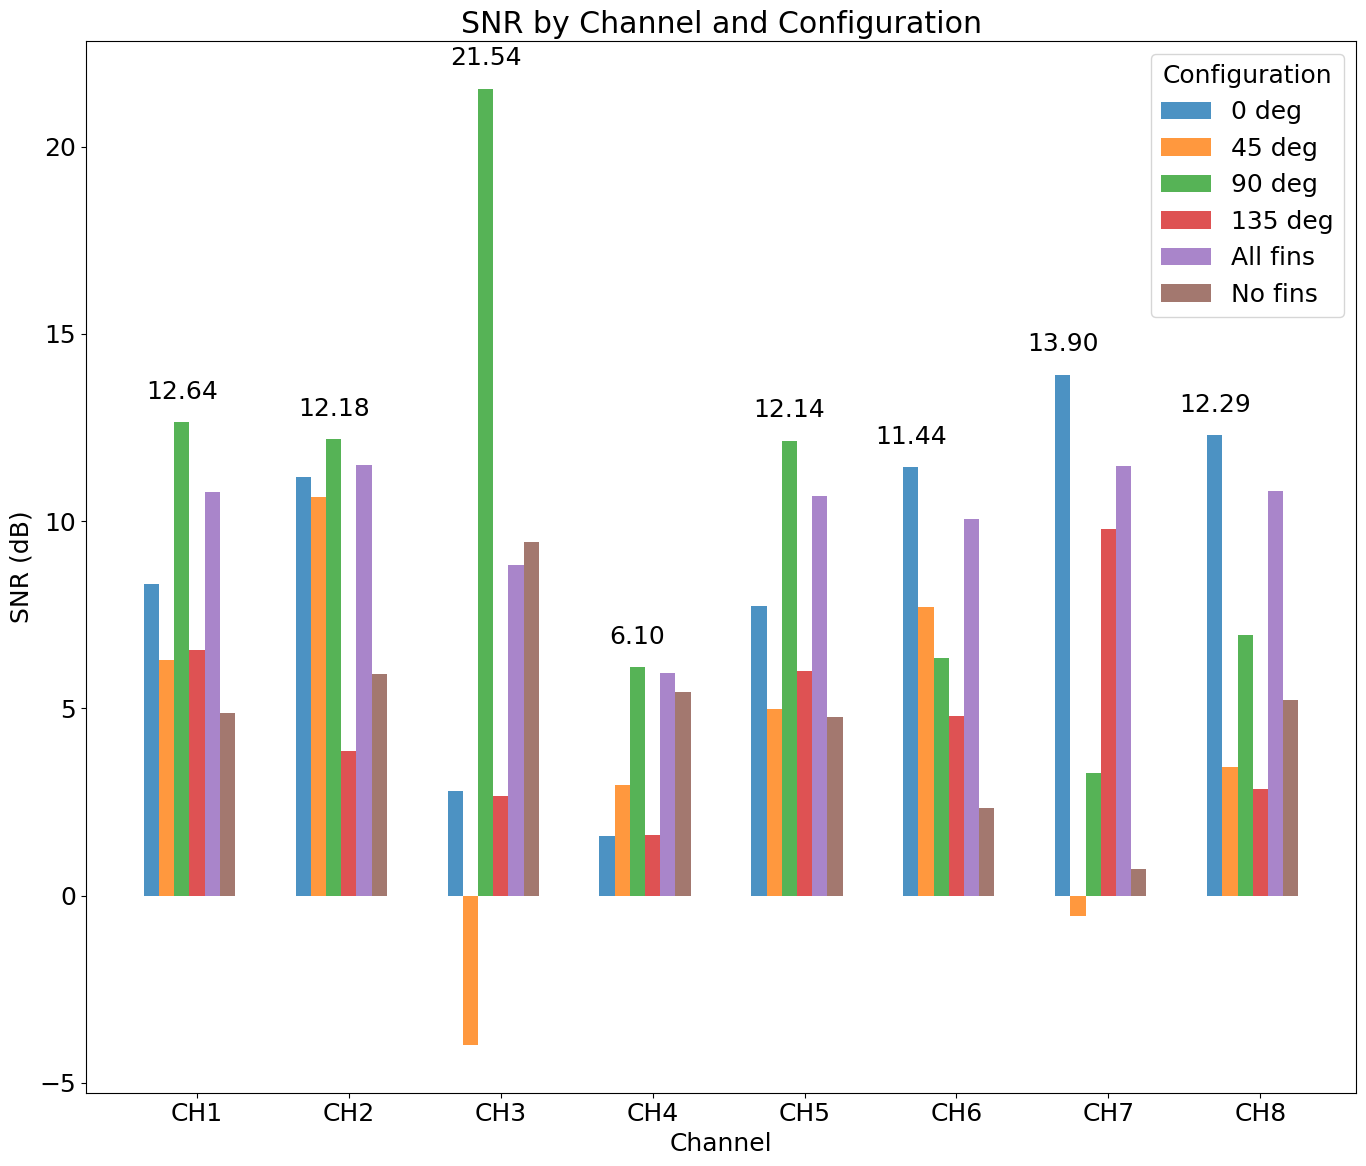

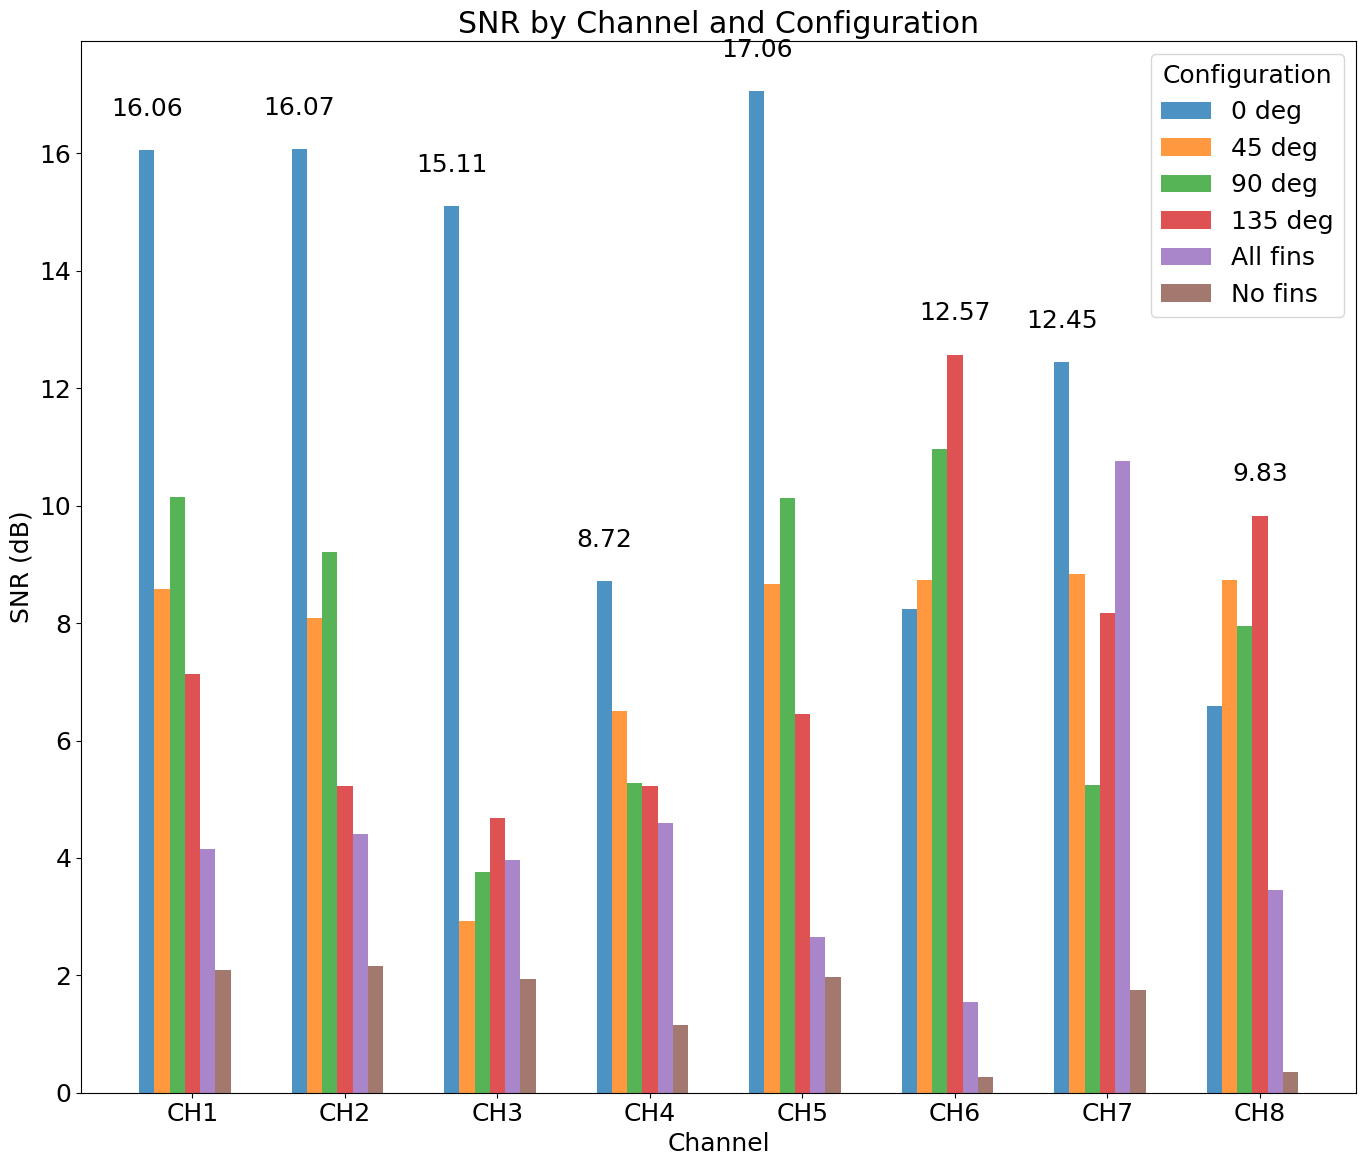

In [7]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})  # Sets the global font size to 16


def plot_revised_grouped_bar_chart(data):
    configurations = data['Configuration']
    channels = list(data.keys())[1:]  # Exclude 'Configuration'
    n_channels = len(channels)
    n_configurations = len(configurations)
    
    # Calculate the positions of each configuration's bar in each group
    index = np.arange(n_channels)  # There will be as many groups as there are channels
    bar_width = 0.1
    opacity = 0.8
    
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(14, 12))

    # Plot bars for each configuration
    for i, config in enumerate(configurations):
        snr_values = [data[channel][i] for channel in channels]
        plt.bar(index + i * bar_width, snr_values, bar_width,
                alpha=opacity,
                label=config)
    
    # Display the highest value for each channel
    for i, channel in enumerate(channels):
        max_value = max(data[channel])
        max_index = data[channel].index(max_value)
        plt.text(index[i] + max_index * bar_width, max_value + 0.5, f'{max_value:.2f}',
                 ha='center', va='bottom')

    plt.xlabel('Channel')
    plt.ylabel('SNR (dB)')
    plt.title('SNR by Channel and Configuration')
    plt.xticks(index + bar_width * (n_configurations / 2), channels)
    plt.legend(title="Configuration")

    plt.tight_layout()
    plt.show()

plot_revised_grouped_bar_chart(data)
plot_revised_grouped_bar_chart(data2)